# SGD Algorithm to predict movie ratings</font>

<b>Predict the rating for a given (user_id, movie_id) pair </b> </font>


<font color='white'> Reading the csv file </font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:

data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/RecommendationSystem_TruncatedSVD/ratings_train.csv')
data.head()

,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


In [ ]:
data.shape

(89992, 3)

<font color='white'>Creating adjacency matrix </font>

In [ ]:
from scipy.sparse import csr_matrix
adjacency_matrix = csr_matrix((data['rating'].values,(data['user_id'].values,data['item_id'].values)), shape=(943,1681))

In [ ]:
adjacency_matrix.shape

(943, 1681)

<font color='white'> SVD decompostion</font>

In [ ]:
# adjacency_matrix as matrix for SVD decompostion
from sklearn.utils.extmath import randomized_svd
import numpy as np 
U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=5,n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 5)
(5,)
(1681, 5)


<font color='white'> Mean of ratings</font>

In [ ]:
def m_u(ratings):
    '''In this function, we will compute mean for all the ratings'''
    m= data['rating'].mean()
    # you can use mean() function to do this
    # check this (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) link for more details.
    

    return m

In [ ]:
mu=m_u(data['rating'])
print(mu)

3.529480398257623


<font color='white'>Initialize $B_{i}$ and $C_{j}$  
Number of rows of adjacent matrix corresponds to user dimensions($B_{i}$), number of columns of adjacent matrix corresponds to movie dimensions ($C_{j}$)

In [ ]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    # initalize the value to zeros 
    # return output as a list of zeros
    init= np.zeros(dim)


    

    return init

In [ ]:
dim= 943 # give the number of dimensions for b_i (Here b_i corresponds to users)
b_i=initialize(dim)

In [ ]:
dim= 1681# give the number of dimensions for c_j (Here c_j corresponds to movies)
c_j=initialize(dim)

In [ ]:
U1, Sigma, V1 = randomized_svd(adjacency_matrix, n_components=2,n_iter=5, random_state=24)
# Please don't change random state
# Here we are considering n_componets = 2 for our convinence
alpha=0.01 
#value=derivative_db(312,98,4,U1,V1,mu,alpha)
diff_b=(2*alpha*b_i[312])-(2*(4-mu-b_i[312]-c_j[98]-np.dot(U[312],VT.T[98])))
print(diff_b)

-0.9229453479130284


<font color='white'> dL/db_i</font>

In [ ]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha,b_i,c_j):
    '''In this function, we will compute dL/db_i'''

    db=(2*alpha*b_i[user_id])-(2*(rating-mu-b_i[user_id]-c_j[item_id]-np.dot(U[user_id],V.T[item_id])))
    #print(db)
    
    return db


<font color='white'> dL/dc_j</font>

In [ ]:
def derivative_dc(user_id,item_id,rating,U,V,mu,b_i,c_j):
    '''In this function, we will compute dL/dc_j'''
    dc= (2*alpha*c_j[item_id])-(2*(rating-mu-b_i[user_id]-c_j[item_id]-np.dot(U[user_id],V.T[item_id])))
    return dc


In [ ]:
adjacency_matrix=adjacency_matrix.todense()
adjacency_matrix=np.array(adjacency_matrix)

In [ ]:
adjacency_matrix[0]

array([5, 0, 4, ..., 0, 0, 0], dtype=int64)

In [ ]:
def pred(mu,b,c,U,V,adjacency_matrix): #predicting Rating
  p=np.empty((len(b),len(c)))
  for i in range(len(b)):
    for j in range(len(c)):
      if adjacency_matrix[i][j]>0:
        p[i][j]=(mu+b[i]+c[j]+np.dot(U[i],V.T[j]))
        #print(np.dot(U[i],V.T[j]))
  return p

<font color='white'>Compute MSE (mean squared error) for predicted ratings</font>


In [ ]:
def MSE(adjacency_matrix,y_pred):#calculating MSE for only Non Zero Values
  score=[]
  for i in range(adjacency_matrix.shape[0]):
    for j in range(adjacency_matrix.shape[1]):
      if adjacency_matrix[i][j]>0:
        #print('act: ',y[i][j],' pred: ',y_pred[i][j])
        score.append((adjacency_matrix[i][j]-y_pred[i][j])**2)
  return (sum(score)/len(score))

In [ ]:
def train(mu,adjacency_matrix,U,V,epochs,alpha,eta0):
    
    db=initialize(U.shape[0])
    dc=initialize(V.shape[1])
    train_loss=[]
    train_pred=pred(mu,db,dc,U,V,adjacency_matrix)
    non_zero=[]

    #print(train_pred[10][458],train_pred[10][458])
    train_loss.append(MSE(adjacency_matrix,train_pred))

    print('Epoch no : 0', ' Train MSE :',train_loss[0])
    
    for i in range(1,epochs):
        
        for j in range(adjacency_matrix.shape[0]): #For all the rating db is updated
          for k in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[j][k]>0 :
              db[j]-=(eta0*(derivative_db(j,k,adjacency_matrix[j][k],U,V,mu,alpha,db,dc)))
              dc[k]-=(eta0*(derivative_dc(j,k,adjacency_matrix[j][k],U,V,mu,db,dc)))
            
        #for l in range(adjacency_matrix.shape[1]): #For all the rating dc is updated
          #for m in range(adjacency_matrix.shape[0]):
            #if adjacency_matrix[m][l]>0:
              #dc[m]=dc[m]-(eta0*(derivative_dc(l,m,adjacency_matrix[l][m],U,V,mu)))
        #print('db :',db,'dc :',dc)
        train_pred=pred(mu,db,dc,U,V,adjacency_matrix)
        train_loss.append(MSE(adjacency_matrix,train_pred))
        #print(b) 
        print('Epoch no : ',i, ' Train MSE :',train_loss[i])   
        if  abs(train_loss[i-1]-train_loss[i])<(0.0001) :
          break
        

        
                

    return train_loss

In [ ]:
loss=train(mu,adjacency_matrix,U,VT,30,0.01,0.01)

Epoch no : 0  Train MSE : 1.264990150913306
Epoch no :  1  Train MSE : 0.9302444154277995
Epoch no :  2  Train MSE : 0.8867618040815735
Epoch no :  3  Train MSE : 0.8724216757435964
Epoch no :  4  Train MSE : 0.8655365362752664
Epoch no :  5  Train MSE : 0.8616403862369124
Epoch no :  6  Train MSE : 0.8591804178390999
Epoch no :  7  Train MSE : 0.8574988963585107
Epoch no :  8  Train MSE : 0.8562788003916725
Epoch no :  9  Train MSE : 0.855352017439205
Epoch no :  10  Train MSE : 0.8546224401415159
Epoch no :  11  Train MSE : 0.8540316415398559
Epoch no :  12  Train MSE : 0.8535422290354416
Epoch no :  13  Train MSE : 0.8531292099080576
Epoch no :  14  Train MSE : 0.852775251801378
Epoch no :  15  Train MSE : 0.8524679510253329
Epoch no :  16  Train MSE : 0.8521981892638477
Epoch no :  17  Train MSE : 0.8519591069235305
Epoch no :  18  Train MSE : 0.8517454398397674
Epoch no :  19  Train MSE : 0.8515530777640243
Epoch no :  20  Train MSE : 0.8513787625755498
Epoch no :  21  Train MSE :

<font color='white'>epoch number vs MSE </font>

In [ ]:
epoch=[]
for i in range(29):
  epoch.append(i)

In [ ]:
import matplotlib.pyplot as plt


Text(0, 0.5, 'loss')

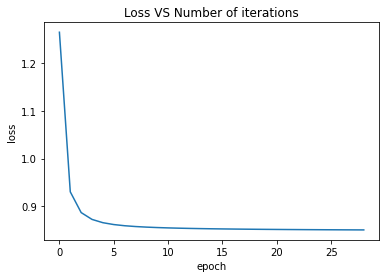

In [ ]:
plt.plot(epoch,loss)
plt.title('Loss VS Number of iterations')
plt.xlabel('epoch')
plt.ylabel('loss')

<br>